# OM 522 - Neighborhood Search
Prepared by Nickolas Freeman, Ph.D.

In this notebook, we will consider neighborhood search techniques commonly employed for single machine scheduling problems. As discussed in class, a common *two-phase* approach to solve a scheduling problem consists of 1) using a construction heuristic to construct an initial solution, e.g., applying a basic or composite dispatching rule, and 2) using a neighborhood search procedure to attempt to improve the solution. We will demonstrate such an approach. First, we will discuss the solution space for a single machine scheduling problem.

#### Aside: The *Solution Space* for a Scheduling Problem

Let's  consider the solution space for a single machine  scheduling problem. In particular, let's consider a 5-job instance for the $1/s_{lj}/\sum_{j=1\ldots n}w_{j}T_{j}$ problem. The following code block imports some libraries we will use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

The following code block shows how we can use Pandas to identify the names of sheets in an Excel file.

In [2]:
pd.ExcelFile('data.xlsx').sheet_names

['job_data_small', 'setup_data_small', 'job_data_large', 'setup_data_large']

The following code block reads in the job data for the *small* (5-job) instance and stores it in a Pandas DataFrame named `job_data`. We set the index of the DataFrame to the job.

In [3]:
# read the job data
job_data = pd.read_excel('data.xlsx', sheet_name = 'job_data_small')

# set the index to the job
job_data = job_data.set_index('Job')

# show the job_data object
job_data

,pj,dj,wj
Job,,,
1,93,310,6
2,76,267,8
3,31,162,1
4,88,298,2
5,23,268,5


The following code block reads in the setup data for the *small* (5-job) instance and stores it in a Pandas DataFrame named `setup_data`. We set the index of the DataFrame to the `From` column.

In [4]:
# read the setup data
setup_data = pd.read_excel('data.xlsx', sheet_name = 'setup_data_small')

# drop the first column and set the index to the from column
setup_data = setup_data.set_index('From')

# show the data
setup_data

,0,1,2,3,4,5
From,,,,,,
0,NaN,14.0,15.0,14.0,14.0,6.0
1,NaN,NaN,21.0,19.0,10.0,5.0
2,NaN,9.0,NaN,9.0,14.0,24.0
3,NaN,9.0,11.0,NaN,24.0,24.0
4,NaN,22.0,12.0,9.0,NaN,18.0
5,NaN,16.0,8.0,6.0,8.0,NaN


The following code block defines a function that computes the total weighted tardiness for a provided sequence.

In [5]:
def Compute_TWT(sequence, job_data, setup_data):
    '''
    This function computes the total weighted tardiness for a sequence. It expects:
    
    1) a sequence provided as a list,
    
    2) a job_data object that is a Pandas DataFrame with the index set as the jobs
    in the provided sequence, a 'pj' column that specifies the processing times for
    the jobs, a 'wj' column that specifies the weights for the jobs, and a 'dj' column
    that specifies the due dates for the jobs
    
    3) a setup_data object that is a Pandas DataFrame with the index set as the job that
    is being setup from, and the column names indicating the job that is being setup to.
    '''
    # initialize current time to zero
    current_t = 0
    
    # initialize previous job (i.e., initial state)
    previous_job = 0
    
    # initialize total weighted tardiness
    TWT = 0
    
    # for each job in the sequence
    for j in sequence:
        
        # determine the job's completion time
        current_t += setup_data.loc[previous_job, j] + job_data.loc[j,'pj']
        
        # update the total weighted tardiness
        TWT += job_data.loc[j,'wj'] * max(current_t - job_data.loc[j,'dj'], 0)
        
        # update the previous job (to the current job) for the next iteration
        previous_job = j
        
    return TWT

The following code block demonstrates the use of the function with our `job_data`, `setup_data`, and the sequence 12345.

In [6]:
sequence = [1, 2, 3, 4, 5]
Compute_TWT(sequence, job_data, setup_data)

843.0

Before continuing, let's consider how the objective function changes as the solution, i.e., the selected sequence, varies. The Python `itertools` library allows us to generate all $5! = 120$ permutations for the small instance. The first 5 are printed in the following cell.

In [7]:
import itertools
permutation_list = list(itertools.permutations(job_data.index))

print('The first 5 permutations are:')
print(permutation_list[0:5])

The first 5 permutations are:
[(1, 2, 3, 4, 5), (1, 2, 3, 5, 4), (1, 2, 4, 3, 5), (1, 2, 4, 5, 3), (1, 2, 5, 3, 4)]


The following code block uses the previously defined `Compute_TWT` function to caluclate the total weighted tardiness associated with a subset of the solutions. The computed tardiness values are stored in a list and plotted. Although the solution representation is **not** smooth in the sense that it contains continuous decision variables, are the plotted results surprising?

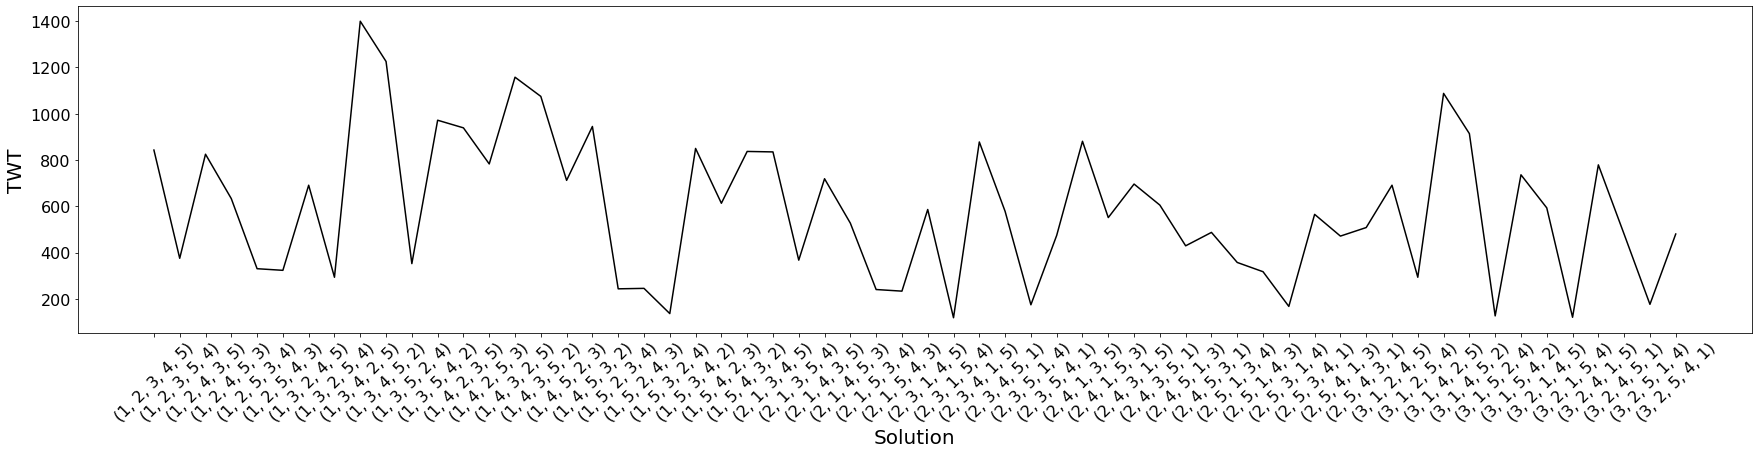

In [8]:
# initialize an empty dictionary
sample_solutions = {}

# for each permutation
for permutation in permutation_list[:60]:
    
    # compute the total weighted tardiness for the current permutation
    # and store the value in the dictionary
    sample_solutions[permutation] = Compute_TWT(permutation, job_data, setup_data)

# setup a blank figure with a single subplot
fig, ax = plt.subplots(figsize=(30,6))

# plot the values stored in the dictionary
ax.plot(list(sample_solutions.values()),'k')

# set the x and y (horizontal and vertical) axis labels
ax.set_xlabel('Solution',fontsize = 20)
ax.set_ylabel('TWT',fontsize = 20)

# change the size of the tick labels
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

# rotate the x tick labels (horizontal axis)
plt.xticks(rotation=45)

# use the dictionary keys as the x tick labels
ax.set_xticks(range(len(sample_solutions)))
ax.set_xticklabels(sample_solutions.keys())

# show the plot
plt.show()

The remainder of the notebook aims to demonstrate the use and benefits of neighborhood search techniques. This demonstration will be based on $\displaystyle 1/s_{lj}/\sum_{j=1\ldots n}w_{j}T_{j}$ instances. For a more meaningful demonstration, we will use a larger dataset with 20 jobs. The following code block reads in the job data, overwriting our `job_data` object.

In [9]:
job_data = pd.read_excel('data.xlsx', sheet_name = 'job_data_large')
job_data = job_data.set_index('Job')
job_data

,pj,dj,wj
Job,,,
1,93,1192,3
2,76,736,2
3,31,1287,6
4,88,796,8
5,23,904,5
6,77,1027,4
7,42,1299,2
8,45,1012,8
9,95,691,4


The following code block reads in the setup data, overwriting our `setup_data` object.

In [10]:
setup_data = pd.read_excel('data.xlsx', sheet_name = 'setup_data_large')
setup_data = setup_data.set_index('From')
setup_data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
From,,,,,,,,,,,,,,,,,,,,,
0,NaN,19.0,20.0,11.0,21.0,14.0,13.0,9.0,12.0,21.0,...,12.0,17.0,20.0,22.0,12.0,21.0,17.0,18.0,16.0,6.0
1,NaN,NaN,14.0,15.0,14.0,14.0,6.0,23.0,12.0,21.0,...,10.0,5.0,21.0,9.0,19.0,9.0,14.0,24.0,7.0,9.0
2,NaN,14.0,NaN,24.0,23.0,22.0,12.0,9.0,17.0,18.0,...,16.0,8.0,6.0,8.0,19.0,6.0,12.0,21.0,19.0,14.0
3,NaN,20.0,21.0,NaN,7.0,18.0,18.0,16.0,13.0,5.0,...,17.0,10.0,19.0,20.0,23.0,5.0,12.0,12.0,21.0,5.0
4,NaN,17.0,10.0,16.0,NaN,14.0,10.0,23.0,6.0,20.0,...,8.0,20.0,22.0,13.0,5.0,23.0,18.0,20.0,23.0,22.0
5,NaN,16.0,24.0,22.0,9.0,NaN,24.0,9.0,14.0,5.0,...,20.0,11.0,14.0,19.0,7.0,24.0,5.0,13.0,13.0,12.0
6,NaN,13.0,15.0,13.0,5.0,20.0,NaN,10.0,8.0,16.0,...,9.0,5.0,7.0,7.0,22.0,6.0,18.0,6.0,23.0,24.0
7,NaN,18.0,14.0,6.0,14.0,5.0,13.0,NaN,9.0,20.0,...,9.0,23.0,6.0,10.0,9.0,23.0,7.0,18.0,6.0,23.0
8,NaN,6.0,23.0,14.0,5.0,22.0,7.0,19.0,NaN,13.0,...,10.0,20.0,24.0,19.0,10.0,22.0,22.0,5.0,13.0,19.0


Later, we will use the Apparent Tardiness Cost with Setups (ATCS) rule to generate some schedules for comparison and initialization purposes. The following code block defines functions that can be used to apply the ATCS rule to a given instance.

In [11]:
def Apply_ATCS(job_data, setup_data):
    '''
    This function applies the Apparent Tardiness Cost with Setups composite
    dispatching rule using provided data. It expects:
       
    1) a job_data object that is a Pandas DataFrame with the index set as the jobs
    in the provided sequence, a 'pj' column that specifies the processing times for
    the jobs, a 'wj' column that specifies the weights for the jobs, and a 'dj' column
    that specifies the due dates for the jobs
    
    2) a setup_data object that is a Pandas DataFrame with the index set as the job that
    is being setup from, and the column names indicating the job that is being setup to.
    '''
    # Compute parameters
    Pavg = job_data['pj'].mean()
    Savg = setup_data.mean().mean()
    Davg = job_data['dj'].mean()
    Cmax_estimate = job_data['pj'].sum() + len(job_data)*Savg
    R = (job_data['dj'].max() - job_data['dj'].min())/Cmax_estimate
    tau = 1 - (Davg/Cmax_estimate)
    eta = Savg/Pavg 
    
    # Compute K values
    if (R <= 0.5):
        k1 = 4.5 + R
    else:
        k1 = 6 - 2 * R     
          
    k2 = tau/(2*np.sqrt(eta))            
    
    # Initialize the start time to 0
    current_t = 0

    # Initialize the previous job to job 0 (the initial state of the single machine)
    previous_job = 0
    
    # Create a list of unscheduled jobs, which includes all jobs initially.
    unscheduled = list(job_data.index)
    
    # Initialize the objective function, i.e., weighted tardiness, to zero.
    TWT = 0  
    
    # Create an empty list to place the scheduled jobs.
    schedule = []

    # While some job(s) is unscheduled
    while unscheduled:

        # Initialize the index and job values
        max_index = -1*np.inf
        max_j = None   
        
        # For all unscheduled jobs
        for j in unscheduled:

            # Compute ATCS index
            slack = np.max(job_data.loc[j,'dj'] - current_t - job_data.loc[j,'pj'], 0)
            ratio_1  = (-1*slack)/(k1*Pavg)
            ratio_2 = (-1*setup_data.loc[previous_job, j])/(k2*Savg)
            index = job_data.loc[j,'wj']/job_data.loc[j,'pj'] * np.exp(ratio_1) * np.exp(ratio_2)

            # If index is the largest
            if (index > max_index):

                # Update the index value
                max_index = index

                # Store the value of j associated with the maximum index value
                max_j = j

        # Append the job with the maximum index value to the end of the scheduled list
        schedule.append(max_j)
        
        # Remove the job with the maximum index value from the scheduled list
        unscheduled.remove(max_j)
        
        #Update the current time
        current_t += setup_data.loc[previous_job, max_j] + job_data.loc[j,'pj']
        
        # Set the selected job as the previous job
        previous_job = max_j
     
    return schedule

The following code block applies the ATCS rule to our instance data. The ATCS schedule is stored in a list named `ATCS_schedule` and the total weighted tardiness associated with the ATCS schedule is stored in a variable named `ATCS_TWT`.

In [12]:
ATCS_schedule = Apply_ATCS(job_data, setup_data)
ATCS_TWT = Compute_TWT(ATCS_schedule, job_data, setup_data)

print(f'The ATCS schedule is {ATCS_schedule}.')
print(f'The associated TWT is {ATCS_TWT}.')

The ATCS schedule is [20, 5, 15, 12, 8, 4, 11, 14, 9, 19, 2, 13, 16, 18, 6, 3, 10, 1, 17, 7].
The associated TWT is 3486.0.


The following code block defines a function that finds a neighbor solution for a provided sequence that can be obtained using a single **adjacent pairwise interchange**.

In [13]:
def get_API_neighbor(sequence):
    '''
    This function determines a neighbor of a provided sequence based on the neighborhood
    of sequences that can be obtained via a single adjacent pairwise interchange
    '''
    # pick the index of the job to interchange
    p1 = np.random.randint(0, len(sequence)-1)
    
    # get the index following p1
    p2 = p1 + 1
    
    # swap the jobs in the stored index positions of the sequence
    sequence[p1], sequence[p2] = sequence[p2], sequence[p1]
    
    return sequence

The following code block demonstrates the correctness of the function.

In [14]:
sequence = [1,2,3,4,5,6,7,8,9,10]
get_API_neighbor(sequence)

[1, 2, 3, 4, 5, 7, 6, 8, 9, 10]

The following code block defines a function that finds a neighbor solution for a provided sequence that can be obtained using a single **pairwise interchange**.

In [15]:
def get_PI_neighbor(sequence):
    '''
    This function determines a neighbor of a provided sequence based on the neighborhood
    of sequences that can be obtained via a single pairwise interchange
    '''
    # pick the index of the first job to interchange
    p1 = np.random.randint(0, len(sequence))
    
    # pick the index of the second job to interchange
    p2 = np.random.randint(0, len(sequence))
    
    # swap the jobs at the stored index values
    sequence[p1], sequence[p2] = sequence[p2], sequence[p1]
    
    return sequence

The following code block demonstrates the correctness of the function.

In [16]:
sequence = [1,2,3,4,5,6,7,8,9,10]
get_PI_neighbor(sequence)

[1, 2, 3, 4, 5, 6, 7, 10, 9, 8]

The following code block defines a function that finds a neighbor solution for a provided sequence that can be obtained using a single **insertion**.

In [17]:
def get_Insertion_neighbor(sequence):
    '''
    This function determines a neighbor of a provided sequence based on the neighborhood
    of sequences that can be obtained via a single insertion
    '''
    # select the job to be inserted
    val = np.random.choice(sequence)
    
    # remove the job from the sequence
    sequence.remove(val)
    
    # select a random index in the sequence
    p = np.random.randint(0, len(sequence))
    
    # insert the selected job at the selected position
    sequence.insert(p, val)
    
    return sequence

The following code block demonstrates the correctness of the function.

In [18]:
sequence = [1,2,3,4,5,6,7,8,9,10]
get_Insertion_neighbor(sequence)

[1, 2, 3, 4, 6, 7, 5, 8, 9, 10]

The following code block defines a function that finds a neighbor solution for a provided sequence that can be obtained using a single **subsequence reversal**.

In [19]:
def get_SSR_neighbor(sequence):
    '''
    This function determines a neighbor of a provided sequence based on the neighborhood
    of sequences that can be obtained via a single subsequence reversal
    '''
    # select two index values, p1 and p2
    p1 = np.random.randint(0, len(sequence))
    p2 = np.random.randint(0, len(sequence))
    
    # if p1 <= p2
    if p1 < p2:
        # reverse the sequence from p1 to p2
        # the +1 is needed to include p2
        sequence[p1:p2+1] = sequence[p1:p2+1][::-1]
    
    # if p2 <= p1
    elif p2 < p1:
        # reverse the sequence from p2 to p1
        # the +1 is needed to include p1
        sequence[p2:p1+1] = sequence[p2:p1+1][::-1]
        
    return sequence

The following code block demonstrates the correctness of the function.

In [20]:
sequence = [1,2,3,4,5,6,7,8,9,10]
get_SSR_neighbor(sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

The following code block defines a function that allows a user to conduct a neighborhood search using the defined neighborhoods. The application terminates whenever *max_iterations* neighbors are inspected without improvement.

In [21]:
def apply_neighborhood_search_TWT(sequence, max_iterations = 100, neighborhood = 'API', verbose = False):
    '''
    This function allows a user to perform a neighborhood search on a specified
    starting sequence. The function assumes the objective is to minimize total
    weighted tardiness. It expects:
       
    1) a python list containing the starting sequence
    2) the user to specify the maximum iterations that should be
    performed without encountering an improving solution (termination criteria)
    3) the neighborhood to consider. Possible values are:
    - 'API' for adjacent pairwise interchanges
    - 'PI' for pairwise interchanges
    - 'Insertion' for insertions
    - 'SSR' for subsequence revresals
    
    The function returns a tuple with the best sequence encountered during the search and 
    the corresponding objective function value. If the verbose argument is set to True, a list 
    containing the best solution value for each iterations is also returned.
    '''
    
    # use neighborhood argument to specify neighbor function
    if neighborhood == 'API':
        neighbor_function = get_API_neighbor
    elif neighborhood == 'PI':
        neighbor_function = get_PI_neighbor
    elif neighborhood == 'Insertion':
        neighbor_function = get_Insertion_neighbor
    elif neighborhood == 'SSR':
        neighbor_function = get_SSR_neighbor
    else:
        print('Invalid neighborhood defined')
        return None

    # initialize and empty list to store objective values
    # over the course of the procedure
    solutions = []
    
    # initialize the best sequence to the starting sequence
    best_sequence = sequence
    
    # initialize the best total weighted tardiness to that of the
    # starting sequence
    best_TWT = Compute_TWT(best_sequence, job_data, setup_data)
    
    # append the best total weighted tardiness to the solutions list
    solutions.append(best_TWT)
    
    # set the iteration counter to 1
    iteration = 1
    
    # while the value of the iteration counter is less than max_iterations
    while iteration < max_iterations:
        # make a copy of the best sequence
        temp_sequence = best_sequence.copy()
        
        # construct a neighbor solution
        temp_sequence = neighbor_function(temp_sequence)
        
        # compute the total weighted tardiness for the neighbor
        temp_TWT = Compute_TWT(temp_sequence, job_data, setup_data)
        
        # if the neighbor's total weighted tardiness is less than the
        # current best total weighted tardiness value
        if(temp_TWT < best_TWT):
            
            # update the best total weighted tardiness value
            best_TWT = temp_TWT
            
            # update the best sequence
            best_sequence = temp_sequence
            
            # reset the iteration counter
            iteration = 1
        else:
            # increment the iteration counter
            iteration += 1
        
        # append the best total weighted tardiness value to the solutions list
        solutions.append(best_TWT)
    
    # if verbose argument is True
    if verbose:
        
        # return sequence, best total weighted tardiness, and solutions list
        return best_sequence, best_TWT, solutions
    
    # else (if verbose argument is False)
    else:
        
        # return sequence, best total weighted tardiness
        return best_sequence, best_TWT

The following code blocks demonstrate a couple of variations of the function.

In [22]:
apply_neighborhood_search_TWT(list(job_data.index), 100, neighborhood = 'API', verbose = False)

([2, 1, 3, 5, 4, 6, 7, 8, 9, 11, 10, 12, 15, 13, 20, 16, 18, 19, 17, 14],
 10798.0)

In [23]:
apply_neighborhood_search_TWT(list(job_data.index), 10, neighborhood = 'Insertion', verbose = True)

([13, 1, 20, 5, 9, 10, 4, 11, 6, 12, 7, 8, 15, 17, 16, 18, 3, 2, 14, 19],
 7212.0,
 [19641.0,
  19641.0,
  19641.0,
  19641.0,
  19641.0,
  19641.0,
  19641.0,
  16546.0,
  16546.0,
  16546.0,
  16546.0,
  16546.0,
  16546.0,
  16266.0,
  14511.0,
  14511.0,
  14346.0,
  14346.0,
  14346.0,
  13642.0,
  13642.0,
  13642.0,
  13124.0,
  13124.0,
  13124.0,
  13042.0,
  12954.0,
  12778.0,
  12778.0,
  12778.0,
  10735.0,
  10735.0,
  10597.0,
  10597.0,
  10597.0,
  10597.0,
  10597.0,
  10597.0,
  10597.0,
  10597.0,
  10459.0,
  10201.0,
  10201.0,
  10201.0,
  10201.0,
  9530.0,
  9530.0,
  8882.0,
  8882.0,
  8669.0,
  8669.0,
  8669.0,
  8669.0,
  8669.0,
  8630.0,
  8630.0,
  8630.0,
  8630.0,
  8013.0,
  8013.0,
  7465.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0,
  7212.0])

The following code block plots the performance of the neighborhood search techniques when a very simple approach is used to construc the initial solution. In particular, we startswith a schedule that sequences the jobs by their index, i.e., $1\rightarrow 2 \rightarrow 3 \rightarrow \ldots \rightarrow n$.

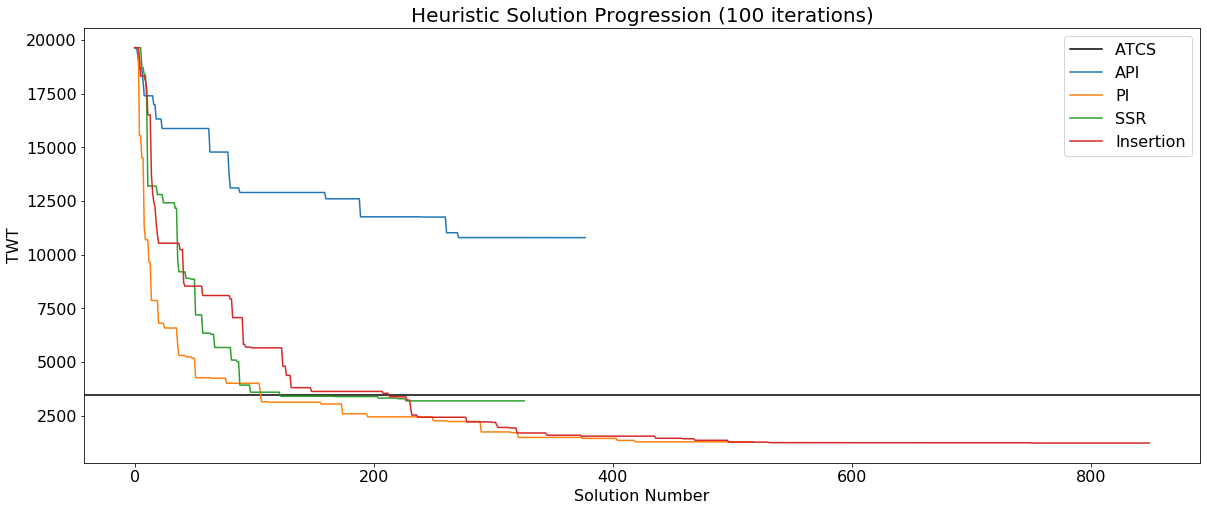

In [24]:
# specify max_iterations
max_iterations = 100

# specify all valid neighborhoods in a list
neighborhoods = ['API', 'PI', 'SSR', 'Insertion']

# initialize a dictionary to store results for each
# neighborhood
solutions_dict = {}

# for each neighborhood
for neighborhood in neighborhoods:
    # specify seed of random number generator for reproducability
    np.random.seed(0)
    
    # apply the neighborhood search using the current neighborhood
    best_sequence, best_TWT, history = apply_neighborhood_search_TWT(list(job_data.index),
                                                                     max_iterations, 
                                                                     neighborhood = neighborhood, 
                                                                     verbose = True)
    # store the results for the current neighborhood in the
    # solutions dictionary
    solutions_dict[neighborhood] = history


# Plot results
fig, ax = plt.subplots(figsize=(20,8))

ax.axhline(ATCS_TWT,color='k', label='ATCS')

for neighborhood in neighborhoods:
    ax.plot(solutions_dict[neighborhood], 
            label=neighborhood)

ax.set_title(f'Heuristic Solution Progression ({max_iterations} iterations)',fontsize=20)
ax.set_xlabel('Solution Number',fontsize = 16)
ax.set_ylabel('TWT',fontsize = 16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(loc=1,fontsize=16)
plt.show()

The following code block provides an interactive version of the previous cell that allows us to observe how the performance changes as the *max_iterations* parameter varies.

In [25]:
from ipywidgets import interact

iteration_list = [10, 100, 1000]

@interact(max_iterations = iteration_list)

def interactive_spend_analysis(max_iterations = iteration_list[0]):
    
    neighborhoods = ['API', 'PI', 'SSR', 'Insertion']

    solutions_dict = {}
    for neighborhood in neighborhoods:
        np.random.seed(0)
        best_sequence, best_TWT, history = apply_neighborhood_search_TWT(list(job_data.index),
                                                                         max_iterations, 
                                                                         neighborhood = neighborhood, 
                                                                         verbose = True)
        solutions_dict[neighborhood] = history


    fig, ax = plt.subplots(figsize=(20,8))

    ax.axhline(ATCS_TWT,color='k', label='ATCS')

    for neighborhood in neighborhoods:
        ax.plot(solutions_dict[neighborhood], 
                label=neighborhood)

    ax.set_title(f'Heuristic Solution Progression ({max_iterations} iterations)',fontsize=20)
    ax.set_xlabel('Solution Number',fontsize = 16)
    ax.set_ylabel('TWT',fontsize = 16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    ax.legend(loc=1,fontsize=16)
    plt.show()

interactive(children=(Dropdown(description='max_iterations', options=(10, 100, 1000), value=10), Output()), _d…

The following code block applies the neighborhood search starting from the ATCS solution.

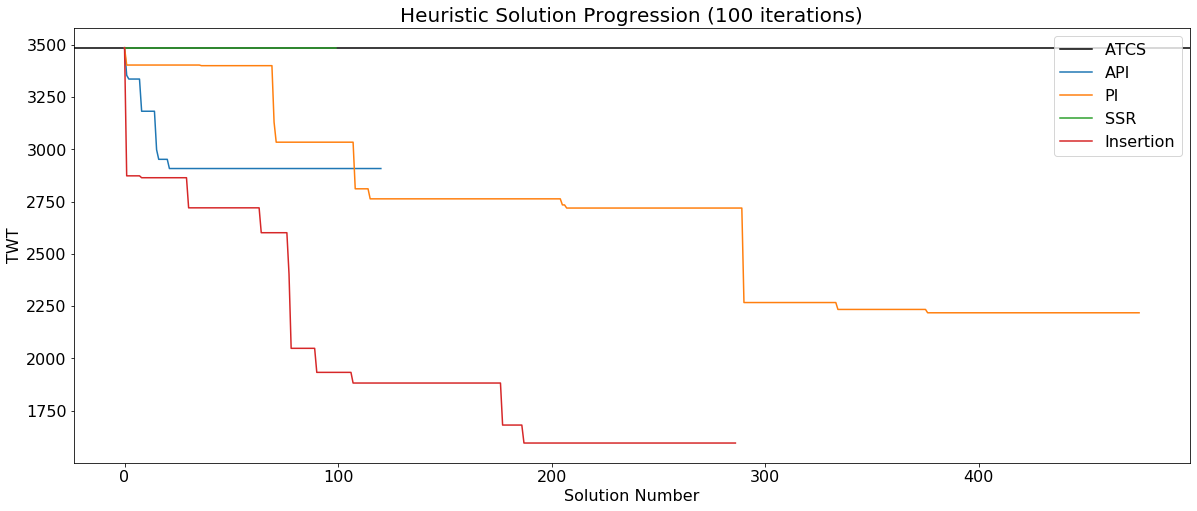

In [26]:
max_iterations = 100
neighborhoods = ['API', 'PI', 'SSR', 'Insertion']

solutions_dict = {}
for neighborhood in neighborhoods:
    np.random.seed(0)
    ATCS_schedule = Apply_ATCS(job_data, setup_data)
    ATCS_TWT = Compute_TWT(ATCS_schedule, job_data, setup_data)
    
    best_sequence, best_TWT, history = apply_neighborhood_search_TWT(ATCS_schedule,
                                                                     max_iterations, 
                                                                     neighborhood = neighborhood, 
                                                                     verbose = True)
    solutions_dict[neighborhood] = history


fig, ax = plt.subplots(figsize=(20,8))

ax.axhline(ATCS_TWT,color='k', label='ATCS')

for neighborhood in neighborhoods:
    ax.plot(solutions_dict[neighborhood], 
            label=neighborhood)

ax.set_title(f'Heuristic Solution Progression ({max_iterations} iterations)',fontsize=20)
ax.set_xlabel('Solution Number',fontsize = 16)
ax.set_ylabel('TWT',fontsize = 16)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

ax.legend(loc=1,fontsize=16)
plt.show()

An interactive version of the previous code block follows.

In [27]:
from ipywidgets import interact

iteration_list = [10, 100, 1000]

@interact(max_iterations = iteration_list)

def interactive_spend_analysis(max_iterations = iteration_list[0]):
    
    neighborhoods = ['API', 'PI', 'SSR', 'Insertion']

    solutions_dict = {}
    for neighborhood in neighborhoods:
        np.random.seed(0)
        
        ATCS_schedule = Apply_ATCS(job_data, setup_data)
        ATCS_TWT = Compute_TWT(ATCS_schedule, job_data, setup_data)
    
        best_sequence, best_TWT, history = apply_neighborhood_search_TWT(ATCS_schedule,
                                                                         max_iterations, 
                                                                         neighborhood = neighborhood, 
                                                                         verbose = True)
        solutions_dict[neighborhood] = history


    fig, ax = plt.subplots(figsize=(20,8))

    ax.axhline(ATCS_TWT,color='k', label='ATCS')

    for neighborhood in neighborhoods:
        ax.plot(solutions_dict[neighborhood], 
                label=neighborhood)

    ax.set_title(f'Heuristic Solution Progression ({max_iterations} iterations)',fontsize=20)
    ax.set_xlabel('Solution Number',fontsize = 16)
    ax.set_ylabel('TWT',fontsize = 16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    ax.legend(loc=1,fontsize=16)
    plt.show()

interactive(children=(Dropdown(description='max_iterations', options=(10, 100, 1000), value=10), Output()), _d…